In [27]:
import pandas as pd
import numpy as np
import math, sys
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, KFold
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from xgboost import XGBRegressor
from IPython.display import display
from itertools import product
from scipy import stats
from scipy.special import boxcox1p, inv_boxcox1p
from scipy.stats import norm, skew
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_rows', 20)
df = pd.read_csv("../data/raw/train.csv")
columns_to_ignore = ['Id']
df.drop(columns=columns_to_ignore, inplace=True)
y_label = 'SalePrice'
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


Impute

In [2]:
def impute_rand(df_input, column):
    print("imputing " + column)
    result = df_input.copy(deep=True)
#     col_avg = df_input[column].mean()
#     col_std = df_input[column].std()
#     col_null_count = df_input[column].isnull().sum()
#     print("{}, {}, {}".format(col_avg - col_std, col_avg + col_std, col_null_count))
#     if col_null_count >= len()
#     col_null_random_list = np.random.randint(col_avg - col_std, col_avg + col_std, size=col_null_count)
#     result[column][np.isnan(df_input[column])] = col_null_random_list
#     result[column] = result[column].astype(int)
    imputer = KNNImputer(n_neighbors=2)
    result[column] = imputer.fit_transform(result[column].values.reshape(-1, 1)).reshape(1, -1)[0]
    
    return result

def impute_mode(df_input, column):
    result = df_input.copy(deep=True)
    col_mode = df_input[column].mode()
    result[column][result[result[column].isna() == True].index] = col_mode[0]
    return result
    
num_impute_col = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
ctg_impute_col = ['Electrical']
ctg_constant_col = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','Fence', 
                    'GarageType','GarageFinish','GarageQual','GarageCond', 'PoolQC', 'MiscFeature', 'Alley']
df_clean = df.copy(deep=True)
for col in num_impute_col:
    df_clean = impute_rand(df_clean, col)
for col in ctg_impute_col:
    df_clean = impute_mode(df_clean, col)
for col in ctg_constant_col:
    df_clean[col].fillna('not equipped', inplace=True)

# add total area feature
df_clean['TotalSF'] = df_clean['TotalBsmtSF'] + df_clean['1stFlrSF'] + df_clean['2ndFlrSF']

imputing LotFrontage
imputing GarageYrBlt
imputing MasVnrArea


feature skewness


Skew in numerical features: 

                   Skew
MiscVal       24.451640
PoolArea      14.813135
LotArea       12.195142
3SsnPorch     10.293752
LowQualFinSF   9.002080
...                 ...
FullBath       0.036524
GarageCars    -0.342197
YearRemodAdd  -0.503044
YearBuilt     -0.612831
GarageYrBlt   -0.667488

[37 rows x 1 columns]
There are 37 skewed numerical features to Box Cox transform


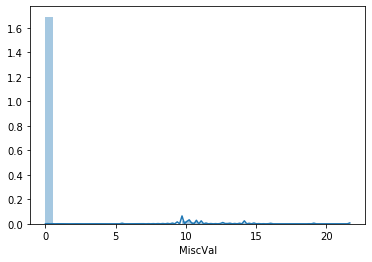

In [472]:
numeric_feats = df_clean.dtypes[df_clean.dtypes != "object"].index.tolist()
numeric_feats.remove(y_label)
# Check the skew of all numerical features
skewed_feats = df_clean[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness)
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
# lambd = 0.15
# for feat in skewed_features:
#     df_clean[feat] = boxcox1p(df_clean[feat], lambd)

sns.distplot(df_clean['MiscVal'])

y label

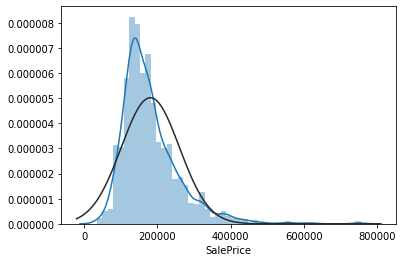

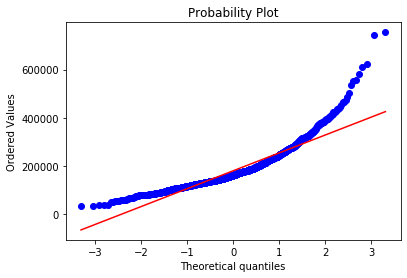

In [397]:
sns.distplot(df['SalePrice'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)
plt.show()

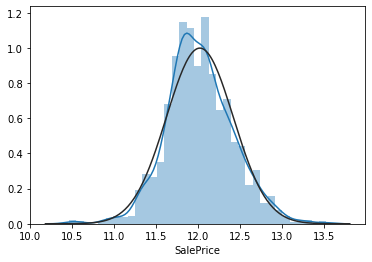

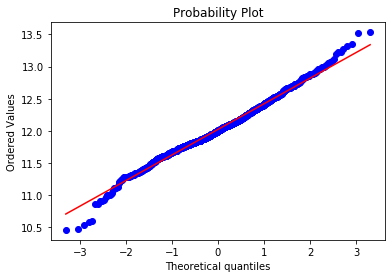

In [450]:
df_ylog = df_clean.copy(deep=True)
df_ylog[y_label] = np.log1p(df_ylog[y_label])
sns.distplot(df_ylog['SalePrice'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df_ylog['SalePrice'], plot=plt)
plt.show()

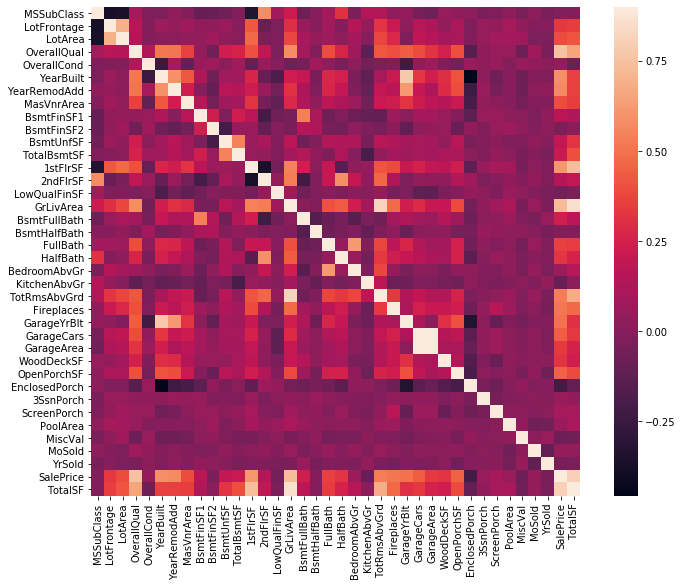

In [361]:
corrmat = df_ylog.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [16]:
df_clean[y_label]

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [17]:
ctg_columns = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
              'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
              'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
              'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
               'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
              'PavedDrive', 'SaleType', 'SaleCondition', 'Fence', 'PoolQC', 'MiscFeature', 'Alley']
num_columns = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
              'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
              'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Bedroom', 
              'Kitchen', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
              'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']

def normalize_data(df_input, scaler='robust'):
    result = df_input.copy(deep=True)
    if scaler == 'robust':
        num_pipeline = Pipeline([('robust_scaler', RobustScaler())])
    else:
        num_pipeline = Pipeline([('std_scaler', StandardScaler())])    
    column_to_nmlz = list(set(df_input.columns) - set([y_label]))
    result[column_to_nmlz] = num_pipeline.fit_transform(df_input[column_to_nmlz])
    return result

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, X, y, scoring='neg_mean_absolute_error', n_jobs=n_jobs, train_sizes=train_sizes, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std, fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    return plt

df_dummy = pd.get_dummies(df_clean, columns=ctg_columns)
#df_dummy_normed[y_label] = df_ylog[y_label]
#y_scaler = RobustScaler().fit(df_dummy[y_label].values.reshape(-1, 1))
y_scaler = StandardScaler().fit(df_dummy[y_label].values.reshape(-1, 1))
df_dummy_normed = normalize_data(df_dummy, scaler='std')
df_dummy_normed[y_label]

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

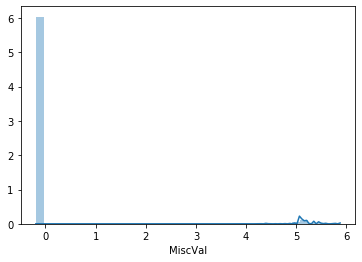

In [375]:
sns.distplot(df_dummy_normed['MiscVal'])

Train-test split

In [21]:
def get_split(df_input, test_size=0.2):
    train_set, test_set = train_test_split(df_input, test_size=test_size, random_state=42)
    x_training = train_set.drop(columns=[y_label], axis=1)
    x_test = test_set.drop(columns=[y_label], axis=1)
    y_training = train_set[y_label]
    y_test = test_set[y_label]
    return x_training, y_training, x_test, y_test

x_training, y_training, x_test, y_test = get_split(df_dummy)
x_training_normed, y_training, x_test_normed, y_test = get_split(df_dummy_normed)
x_training_normed

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PoolQC_Gd,PoolQC_not equipped,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_not equipped,Alley_Grvl,Alley_Pave,Alley_not equipped
254,-0.872563,-0.002269,-0.212153,-0.795151,0.381743,-0.472560,-1.350194,-0.574410,1.049169,-0.288653,...,-0.045376,0.069409,-0.037037,-0.037037,-0.186352,-0.02618,0.195977,-0.188311,-0.169981,0.257821
1066,0.073375,-0.501895,-0.268578,-0.071836,1.280685,0.719786,0.442586,-0.574410,-0.973018,-0.288653,...,-0.045376,0.069409,-0.037037,-0.037037,-0.186352,-0.02618,0.195977,-0.188311,-0.169981,0.257821
638,-0.636078,-0.138531,-0.174369,-0.795151,1.280685,-2.029235,-1.689368,-0.574410,-0.973018,-0.288653,...,-0.045376,0.069409,-0.037037,-0.037037,-0.186352,-0.02618,0.195977,-0.188311,-0.169981,0.257821
799,-0.163109,-0.456474,-0.332419,-0.795151,1.280685,-1.134975,-1.689368,0.821655,0.274948,-0.288653,...,-0.045376,0.069409,-0.037037,-0.037037,-0.186352,-0.02618,0.195977,-0.188311,-0.169981,0.257821
380,-0.163109,-0.910680,-0.552908,-0.795151,0.381743,-1.565545,-1.689368,-0.574410,-0.494887,-0.288653,...,-0.045376,0.069409,-0.037037,-0.037037,-0.186352,-0.02618,0.195977,-0.188311,5.883006,-3.878654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,-0.872563,0.361095,-0.120249,-0.071836,-0.517200,1.150356,1.024029,-0.574410,-0.920380,-0.288653,...,-0.045376,0.069409,-0.037037,-0.037037,-0.186352,-0.02618,0.195977,-0.188311,-0.169981,0.257821
1130,-0.163109,-0.229372,-0.271885,-1.518467,-2.315085,-1.433062,-1.689368,-0.574410,0.391191,-0.288653,...,-0.045376,0.069409,-0.037037,-0.037037,-0.186352,-0.02618,0.195977,-0.188311,-0.169981,0.257821
1294,-0.872563,-0.456474,-0.235003,-0.795151,1.280685,-0.538802,0.248772,-0.574410,-0.606743,-0.288653,...,-0.045376,0.069409,-0.037037,-0.037037,-0.186352,-0.02618,0.195977,-0.188311,-0.169981,0.257821
860,-0.163109,-0.683577,-0.288121,0.651479,2.179628,-1.764269,0.636400,-0.574410,-0.973018,-0.288653,...,-0.045376,0.069409,-0.037037,-0.037037,-0.186352,-0.02618,0.195977,-0.188311,-0.169981,0.257821


In [5]:
pd.set_option('display.max_rows', 20)
df_test = pd.read_csv("../data/raw/test.csv")
Ids = df_test['Id']
columns_to_ignore = ['Id']
num_impute_col = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
ctg_impute_col = ['Electrical']
ctg_constant_col = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType',
                    'GarageFinish','GarageQual','GarageCond', 'Fence', 'PoolQC', 'MiscFeature', 'Alley']
df_test.drop(columns=columns_to_ignore, inplace=True)
for col in num_impute_col:
    df_test = impute_rand(df_test, col)
for col in ctg_impute_col:
    df_test = impute_mode(df_test, col)
for col in ctg_constant_col:
    df_test[col].fillna('not equipped', inplace=True)

# add total area feature
df_test['TotalSF'] = df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF']

test_final_columns = list(df_dummy.columns)
test_final_columns.remove(y_label)
df_test_dummy = pd.DataFrame(columns=test_final_columns)
for idx, row in df_test.iterrows():
    series_dict = {}
    for col in test_final_columns:
        if '_' in col:
            ctg_name, ctg_value = col.split('_')
            series_dict[col] = 1 if row[ctg_name] == ctg_value else 0
        else:
            series_dict[col] = row[col]
    df_test_dummy= df_test_dummy.append(series_dict, ignore_index=True)
    
df_test_dummy_normed = normalize_data(df_test_dummy, scaler='std')

# lambd = 0.15
# for feat in skewed_features:
#     df_test_dummy[feat] = boxcox1p(df_test_dummy[feat], lambd)

df_test_dummy

imputing LotFrontage
imputing GarageYrBlt
imputing MasVnrArea
imputing BsmtFinSF1
imputing BsmtFinSF2
imputing BsmtUnfSF
imputing TotalBsmtSF
imputing BsmtFullBath
imputing BsmtHalfBath
imputing GarageCars
imputing GarageArea


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PoolQC_Gd,PoolQC_not equipped,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_not equipped,Alley_Grvl,Alley_Pave,Alley_not equipped
0,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160.0,21.0,1936.0,4.0,7.0,1970.0,1970.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1455,160.0,21.0,1894.0,4.0,5.0,1970.0,1970.0,0.0,252.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1456,20.0,160.0,20000.0,5.0,7.0,1960.0,1996.0,0.0,1224.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1457,85.0,62.0,10441.0,5.0,5.0,1992.0,1992.0,0.0,337.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Random Forest regressor

In [28]:
def mape(y_preds, y_test, **kwargs):
    return np.absolute((y_preds - y_test) / y_test).mean()

def train_n_evaluate(model, cv=3, scoring='mape'):
    print("training model... ")
    #model.fit(x_training, y_training)
    print("getting validation scores...")
    scores = -cross_val_score(model, x_training, y_training, cv=cv, scoring=make_scorer(mape, greater_is_better=False))
    print("cross val scores for score:{}, avg:{}, std:{}".format(scores, scores.mean(), scores.std()))
    
def dict_product(d):
    keys = d.keys()
    for element in product(*d.values()):
        yield dict(zip(keys, element))
      
    
def evaluate_on_testset(model, x_normed=False, y_normed=False):
    error = 0;
    if y_normed == True:
        
        y_preds_train = model.predict(x_training_normed if x_normed == True else x_training)
        print("y_preds_train:{}".format(y_preds_train))
        predictions_train = y_scaler.inverse_transform(y_preds_train)
        print("inverse:{}".format(predictions_train))
        #sns.distplot(predictions_train)
        #predictions_train = np.expm1(predictions_train.reshape(1,-1)[0])
        #print("inv_boxcox1p:{}".format(predictions_train))
        mae_train = np.absolute((predictions_train.reshape(1, -1) - y_training.values)).mean()
        print("MAE on training set: {}".format(mae_train))
        
        y_preds_test = model.predict(x_test_normed if x_normed == True else x_test)
        predictions_test = y_scaler.inverse_transform(y_preds_test)
        #predictions_test = np.expm1(predictions_test.reshape(1,-1)[0])
        mae_test = np.absolute((predictions_test.reshape(1, -1) - y_test.values)).mean()
        print("MAE on test set: {}".format(mae_test))
    else:
        predictions_train = model.predict(x_training_normed if x_normed == True else x_training)
        mae_train = np.absolute((predictions_train.reshape(1, -1) - y_training.values)).mean()
        print("MAE on training set: {}".format(mae_train))
        
        predictions_test = model.predict(x_test_normed if x_normed == True else x_test)
        mae_test = np.absolute((predictions_test.reshape(1, -1) - y_test.values)).mean()
        print("MAE on test set: {}".format(mae_test))
    
def GridSearchWithVal(model_class, param_grid, metrics='mape', cv=5, x_input=None, y_input=None):
    combinations = list(dict_product(param_grid))
    min_metrics = math.inf
    best_comb = None
    X = x_input if x_input is not None else x_training_normed
    Y = y_input if y_input is not None else y_training
    print("{} combinations in total".format(len(combinations)))
    for idx, comb in enumerate(combinations):        
        model = model_class(**comb)
        #model.fit(x_training, y_training)
        #y_preds = model.predict(x_test)
        error = 0;
        if metrics == 'mape':
            if cv == 0:
                model.fit(X, Y)
                y_preds = model.predict(x_test)
                metrics_num = np.absolute((y_preds - y_test) / y_test).mean()
            else:
                scores = -cross_val_score(model, X, Y, cv=cv, scoring=make_scorer(mape, greater_is_better=False))
                metrics_num = scores.mean()
        else:
            metrics_num = np.absolute(y_preds - y_test).mean()
        if metrics_num < min_metrics:
            min_metrics = metrics_num
            best_comb = comb
        progress_str = "{} / {}, best comb: {}, best score: {}".format(idx + 1, len(combinations), best_comb, min_metrics)
        sys.stdout.write('\r' + progress_str)
            
    print("best params:{}".format(best_comb))
    print("min {}: {}".format(metrics, min_metrics))
    return best_comb


In [29]:
title = "Learning Curves"
rf_param_grid = {"n_estimators" : [10, 50, 100, 150, 200, 300, 500],
                  "criterion" : ["mae"],
                  "max_depth": [5, 6, 7, 8, None],
                  "max_features": [0.2, 0.5, 'sqrt', 'auto'],
                  "min_samples_split": [2, 3, 4, 5],
                  "min_samples_leaf": [1, 3],
                  "bootstrap": [True, False]
                 }
rf_best = GridSearchWithVal(RandomForestRegressor, rf_param_grid, metrics='mape')
rf_best_model = RandomForestRegressor(**rf_best)
train_n_evaluate(rf_best_model, 'random_forest', cv=10)

2240 combinations in total
3 / 2240, best comb: {'n_estimators': 10, 'criterion': 'mae', 'max_depth': 5, 'max_features': 0.2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}, best score: 0.11175934344749719

KeyboardInterrupt: 

In [131]:
y_pred_1 = rf_reg.predict(df_test_dummy)
y_pred_1
df_output_1 = pd.DataFrame(data={'Id': Ids, 'SalePrice': y_pred_1})
df_output_1.to_csv("../data/processed/submission_1.csv", index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


In [693]:
rf_best_params = {'n_estimators': 2000, 'criterion': 'mae', 'max_depth': None, 'max_features': 0.2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}
rf_best = RandomForestRegressor(**rf_best_params, n_jobs=-1)
rf_reg.fit(x_training, y_training)
evaluate_on_testset(rf_reg, x_normed=False, y_normed=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


MAE on training set: 6355.037739726027
MAE on test set: 17503.158938356166


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


XGBoost regressor

In [531]:
xgb_param_grid = {"objective" : ['reg:squarederror'],
                  "n_estimators": [150, 200, 250, 300, 500],
                  "base_score" : [0.01, 0.02, 0.03, 0.04],
                  "max_depth": [4, 5, 6, 7],
                  "gamma": [0.001, 0.003, 0.005, 0.01],
                  "min_child_weight": range(1, 8, 2),
                  "learning_rate": [0.01, 0.05, 0.1, 0.2]
                 }
xgb_best = GridSearchWithVal(XGBRegressor, xgb_param_grid)

5120 combinations in total
{'objective': 'reg:squarederror', 'n_estimators': 150, 'base_score': 0.01, 'max_depth': 4, 'gamma': 0.001, 'min_child_weight': 1, 'learning_rate': 0.01}
{'objective': 'reg:squarederror', 'n_estimators': 150, 'base_score': 0.01, 'max_depth': 4, 'gamma': 0.001, 'min_child_weight': 1, 'learning_rate': 0.05}
{'objective': 'reg:squarederror', 'n_estimators': 150, 'base_score': 0.01, 'max_depth': 4, 'gamma': 0.001, 'min_child_weight': 1, 'learning_rate': 0.1}
{'objective': 'reg:squarederror', 'n_estimators': 150, 'base_score': 0.01, 'max_depth': 4, 'gamma': 0.001, 'min_child_weight': 1, 'learning_rate': 0.2}
{'objective': 'reg:squarederror', 'n_estimators': 150, 'base_score': 0.01, 'max_depth': 4, 'gamma': 0.001, 'min_child_weight': 3, 'learning_rate': 0.01}
{'objective': 'reg:squarederror', 'n_estimators': 150, 'base_score': 0.01, 'max_depth': 4, 'gamma': 0.001, 'min_child_weight': 3, 'learning_rate': 0.05}


KeyboardInterrupt: 

In [689]:
df_dummy.drop(columns=[y_label])

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,PoolQC_Gd,PoolQC_not equipped,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscFeature_not equipped,Alley_Grvl,Alley_Pave,Alley_not equipped
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,1,0,0,0,0,1,0,0,1
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,1,0,0,0,0,1,0,0,1
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,1,0,0,0,0,1,0,0,1
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,1,0,0,0,0,1,0,0,1
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,1,0,0,0,0,1,0,0,1
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,1,0,0,0,0,1,0,0,1
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,1,0,0,1,0,0,0,0,1
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,0,1,0,0,0,0,1,0,0,1


In [690]:
xbg_best_params = {'objective': 'reg:squarederror', 'n_estimators': 3000, 'base_score': 0.04, 'max_depth': 6,
                   'gamma': 0.001, 'min_child_weight': 5, 'learning_rate': 0.01}
xgb_reg = XGBRegressor(**xbg_best_params, n_jobs=-1)
#train_n_evaluate(xgb_reg, cv=5, scoring='neg_mean_absolute_error')
#plot_learning_curve(xgb_reg, "xgboost", x_training, y_training,  n_jobs=4)
xgb_reg.fit(df_dummy.drop(columns=[y_label]), df_dummy[y_label])
evaluate_on_testset(xgb_reg, x_normed=False, y_normed=False)
#xgb_reg = XGBRegressor(**xgb_best)


MAE on training set: 1718.5942717251712
MAE on test set: 1859.828780500856


In [692]:
predictions = xgb_reg.predict(df_test_dummy)
#y_pred_2 = y_scaler.inverse_transform(predictions)
predictions.reshape(1, -1)[0]
df_output_10 = pd.DataFrame(data={'Id': Ids, 'SalePrice': predictions.reshape(1, -1)[0]})
df_output_10.to_csv("../data/processed/submission_10.csv", index=False)

In [593]:
xgb = make_pipeline(RobustScaler(), xgb_reg)
evaluate_on_testset(xgb, x_normed=False, y_normed=False)
#predictions = xgb_reg.predict(df_test_dummy)
#print(predictions)
#df_output_4 = pd.DataFrame(data={'Id': Ids, 'SalePrice': predictions})
#df_output_4.to_csv("../data/processed/submission_4.csv", index=False)

NotFittedError: This RobustScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

Gradient Boosting Regressor

In [573]:
gb_param_grid = {"n_estimators" : [200, 1000, 1500, 2000],
                  "loss" : ["huber", "lad"],
                  "learning_rate": [0.01, 0.005, 0.1],
                  "max_depth": [4, 5, 6, 7],
                  "min_samples_leaf": [50, 100, 120],
                  "max_features": [0.5, 0.3, None] 
                 }
gb_best = GridSearchWithVal(GradientBoostingRegressor, gb_param_grid)

864 combinations in total
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 50, 'max_features': None}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 120, 'max

{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 120, 'max_features': 0.3}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 120, 'max_features': None}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_

{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': 0.3}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': None}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 50, 'max_features': None}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 200, 'l

{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': 0.3}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': None}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 200, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 200, 'loss': 'l

{'n_estimators': 1000, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_estimators': 1000, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 120, 'max_features': 0.3}
{'n_estimators': 1000, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 120, 'max_features': None}
{'n_estimators': 1000, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 6, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 1000, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 6, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 1000, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 6, 'min_samples_leaf': 50, 'max_features': None}
{'n_estimators': 1000, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 6, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 1000, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 6, 'min_samples_leaf': 100, 'max_features'

{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 50, 'max_features': None}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 120, 'max_features': 0.3}
{'n_estimators': 

{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 120, 'max_features': 0.3}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 120, 'max_features': None}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 1000, 'loss': 'lad', 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 50, 'max_features': None}
{'n_estimators': 1000, '

{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 120, 'max_features': None}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 4, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 4, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 4, 'min_samples_leaf': 50, 'max_features': None}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 4, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 4, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 4, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.005, 'max_depth': 4, 'min_samples_leaf': 120, 'max_features'

{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 50, 'max_features': None}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 120, 'max_features': 0.3}
{'n_estimators': 1500, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 120, 'max_features': None}
{'n_estimators': 1500, 'loss': 'lad', 'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_esti

{'n_estimators': 1500, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_estimators': 1500, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': 0.3}
{'n_estimators': 1500, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': None}
{'n_estimators': 1500, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 1500, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 1500, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 50, 'max_features': None}
{'n_estimators': 1500, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 1500, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 7, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estim

{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 50, 'max_features': None}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': 0.3}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 120, 'max_features': None}

{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 120, 'max_features': 0.3}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 120, 'max_features': None}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 2000, 'loss': 'huber', 'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 50, 'max_features': None}
{'n_esti

{'n_estimators': 2000, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 4, 'min_samples_leaf': 120, 'max_features': None}
{'n_estimators': 2000, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 50, 'max_features': 0.5}
{'n_estimators': 2000, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 50, 'max_features': 0.3}
{'n_estimators': 2000, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 50, 'max_features': None}
{'n_estimators': 2000, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 100, 'max_features': 0.5}
{'n_estimators': 2000, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 100, 'max_features': 0.3}
{'n_estimators': 2000, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 100, 'max_features': None}
{'n_estimators': 2000, 'loss': 'lad', 'learning_rate': 0.005, 'max_depth': 5, 'min_samples_leaf': 120, 'max_features': 0.5}
{'n_esti

In [696]:
gb_best = {'n_estimators': 2500, 'loss': 'huber', 'learning_rate': 0.01, 'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 10, 'max_features': 'sqrt'}
gb_reg = GradientBoostingRegressor(**gb_best)
#train_n_evaluate(xgb_reg, cv=5, scoring='neg_mean_absolute_error')
#plot_learning_curve(xgb_reg, "xgboost", x_training, y_training,  n_jobs=4)
gb_reg.fit(x_training, y_training)
evaluate_on_testset(gb_reg, x_normed=False, y_normed=False)

MAE on training set: 6292.247416943706
MAE on test set: 14668.675402691402


In [700]:
gb_reg.fit(df_dummy.drop(columns=[y_label]), df_dummy[y_label])
predictions = gb_reg.predict(df_test_dummy)
#y_pred_2 = y_scaler.inverse_transform(predictions)
predictions.reshape(1, -1)[0]
df_output_10 = pd.DataFrame(data={'Id': Ids, 'SalePrice': predictions.reshape(1, -1)[0]})
df_output_10.to_csv("../data/processed/submission_10.csv", index=False)

In [702]:
x_training_normed.to_csv("/Users/macbook/Desktop/x_training_normed.csv")
y_training_normed.to_csv("/Users/macbook/Desktop/y_training_normed.csv")

MLP

Keras model constructed
Train on 1168 samples, validate on 292 samples
Epoch 1/300
1168/1168 [==============================] - 4s 4ms/step - loss: 0.5642 - coeff_determination: 0.3388 - val_loss: 0.5293 - val_coeff_determination: 0.5648
Epoch 2/300
1168/1168 [==============================] - 0s 182us/step - loss: 0.3643 - coeff_determination: 0.6768 - val_loss: 0.2745 - val_coeff_determination: 0.8281
Epoch 3/300
1168/1168 [==============================] - 0s 153us/step - loss: 0.2263 - coeff_determination: 0.8546 - val_loss: 0.2804 - val_coeff_determination: 0.8106
Epoch 4/300
1168/1168 [==============================] - 0s 179us/step - loss: 0.1959 - coeff_determination: 0.8699 - val_loss: 0.2432 - val_coeff_determination: 0.8519
Epoch 5/300
1168/1168 [==============================] - 0s 149us/step - loss: 0.1840 - coeff_determination: 0.8622 - val_loss: 0.2504 - val_coeff_determination: 0.8417
Epoch 6/300
1168/1168 [==============================] - 0s 185us/step - loss: 0.1642 

Epoch 49/300
1168/1168 [==============================] - 0s 149us/step - loss: 0.0629 - coeff_determination: 0.9846 - val_loss: 0.2204 - val_coeff_determination: 0.8797
Epoch 50/300
1168/1168 [==============================] - 0s 144us/step - loss: 0.0597 - coeff_determination: 0.9856 - val_loss: 0.2218 - val_coeff_determination: 0.8746
Epoch 51/300
1168/1168 [==============================] - 0s 145us/step - loss: 0.0633 - coeff_determination: 0.9853 - val_loss: 0.2126 - val_coeff_determination: 0.8835
Epoch 52/300
1168/1168 [==============================] - 0s 145us/step - loss: 0.0627 - coeff_determination: 0.9859 - val_loss: 0.2191 - val_coeff_determination: 0.8727
Epoch 53/300
1168/1168 [==============================] - 0s 138us/step - loss: 0.0585 - coeff_determination: 0.9864 - val_loss: 0.2173 - val_coeff_determination: 0.8834
Epoch 54/300
1168/1168 [==============================] - 0s 136us/step - loss: 0.0606 - coeff_determination: 0.9867 - val_loss: 0.2201 - val_coeff_de

1168/1168 [==============================] - 0s 144us/step - loss: 0.0411 - coeff_determination: 0.9945 - val_loss: 0.2084 - val_coeff_determination: 0.8947
Epoch 146/300
1168/1168 [==============================] - 0s 142us/step - loss: 0.0416 - coeff_determination: 0.9943 - val_loss: 0.2176 - val_coeff_determination: 0.8829
Epoch 147/300
1168/1168 [==============================] - 0s 142us/step - loss: 0.0380 - coeff_determination: 0.9958 - val_loss: 0.2156 - val_coeff_determination: 0.8932
Epoch 148/300
1168/1168 [==============================] - 0s 142us/step - loss: 0.0365 - coeff_determination: 0.9953 - val_loss: 0.2133 - val_coeff_determination: 0.8919
Epoch 149/300
1168/1168 [==============================] - 0s 142us/step - loss: 0.0407 - coeff_determination: 0.9943 - val_loss: 0.2126 - val_coeff_determination: 0.8921
Epoch 150/300
1168/1168 [==============================] - 0s 146us/step - loss: 0.0394 - coeff_determination: 0.9951 - val_loss: 0.2151 - val_coeff_determinat

Epoch 193/300
1168/1168 [==============================] - 0s 145us/step - loss: 0.0370 - coeff_determination: 0.9953 - val_loss: 0.2130 - val_coeff_determination: 0.8919
Epoch 194/300
1168/1168 [==============================] - 0s 145us/step - loss: 0.0357 - coeff_determination: 0.9962 - val_loss: 0.2104 - val_coeff_determination: 0.8942
Epoch 195/300
1168/1168 [==============================] - 0s 144us/step - loss: 0.0369 - coeff_determination: 0.9960 - val_loss: 0.2130 - val_coeff_determination: 0.8935
Epoch 196/300
1168/1168 [==============================] - 0s 149us/step - loss: 0.0331 - coeff_determination: 0.9968 - val_loss: 0.2049 - val_coeff_determination: 0.8953
Epoch 197/300
1168/1168 [==============================] - 0s 141us/step - loss: 0.0370 - coeff_determination: 0.9957 - val_loss: 0.2122 - val_coeff_determination: 0.8903
Epoch 198/300
1168/1168 [==============================] - 0s 144us/step - loss: 0.0352 - coeff_determination: 0.9959 - val_loss: 0.2089 - val_co

Epoch 241/300
1168/1168 [==============================] - 0s 146us/step - loss: 0.0334 - coeff_determination: 0.9964 - val_loss: 0.2153 - val_coeff_determination: 0.8852
Epoch 242/300
1168/1168 [==============================] - 0s 144us/step - loss: 0.0332 - coeff_determination: 0.9967 - val_loss: 0.2073 - val_coeff_determination: 0.8930
Epoch 243/300
1168/1168 [==============================] - 0s 150us/step - loss: 0.0313 - coeff_determination: 0.9969 - val_loss: 0.2155 - val_coeff_determination: 0.8822
Epoch 244/300
1168/1168 [==============================] - 0s 145us/step - loss: 0.0333 - coeff_determination: 0.9964 - val_loss: 0.2093 - val_coeff_determination: 0.8915
Epoch 245/300
1168/1168 [==============================] - 0s 147us/step - loss: 0.0343 - coeff_determination: 0.9964 - val_loss: 0.2182 - val_coeff_determination: 0.8880
Epoch 246/300
1168/1168 [==============================] - 0s 145us/step - loss: 0.0339 - coeff_determination: 0.9963 - val_loss: 0.2135 - val_co

Epoch 289/300
1168/1168 [==============================] - 0s 147us/step - loss: 0.0282 - coeff_determination: 0.9976 - val_loss: 0.2128 - val_coeff_determination: 0.8917
Epoch 290/300
1168/1168 [==============================] - 0s 144us/step - loss: 0.0288 - coeff_determination: 0.9974 - val_loss: 0.2117 - val_coeff_determination: 0.8878
Epoch 291/300
1168/1168 [==============================] - 0s 144us/step - loss: 0.0298 - coeff_determination: 0.9973 - val_loss: 0.2106 - val_coeff_determination: 0.8888
Epoch 292/300
1168/1168 [==============================] - 0s 146us/step - loss: 0.0308 - coeff_determination: 0.9971 - val_loss: 0.2100 - val_coeff_determination: 0.8960
Epoch 293/300
1168/1168 [==============================] - 0s 145us/step - loss: 0.0293 - coeff_determination: 0.9973 - val_loss: 0.2108 - val_coeff_determination: 0.8923
Epoch 294/300
1168/1168 [==============================] - 0s 145us/step - loss: 0.0303 - coeff_determination: 0.9975 - val_loss: 0.2121 - val_co

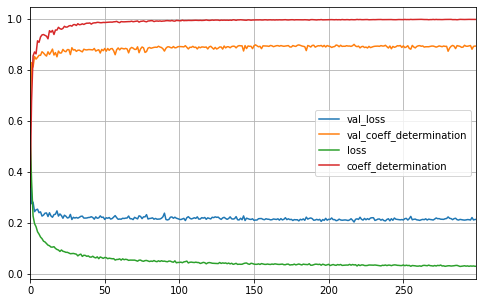

In [640]:
def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def create_keras_model(optimizer='adam', neuron=50, init='lecun_normal', act_alpha=0.01):
    model_sequences = [
        keras.layers.Dense(units=neuron, kernel_initializer=init, 
                           #activation='relu',
                           input_shape=x_training_normed.shape[1:]
                          ),
        
        keras.layers.LeakyReLU(alpha=act_alpha)
    ]

    for i in range(3):
        model_sequences.append(keras.layers.Dense(units=neuron, kernel_initializer=init,
                                                  #activation='elu',
                                                  input_shape=x_training_normed.shape[1:]))
        model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))

    #model_sequences.append(keras.layers.BatchNormalization())
    model_sequences.append(Dense(units=1, name='score_output',
                                 #activation='elu'
                                ))
    model_sequences.append(keras.layers.LeakyReLU(alpha=act_alpha))

    nn_model = keras.models.Sequential(model_sequences)
    nn_model.compile(optimizer=optimizer, loss='mae', metrics=[coeff_determination])
    return nn_model

nn_model = create_keras_model(optimizer='adadelta', neuron=50, init='lecun_uniform', act_alpha=0.05)
print("Keras model constructed")
#early_stopping_cb = EarlyStopping(patience=20)
history = nn_model.fit(x_training_normed, y_training_normed, validation_data=(x_test_normed, y_test_normed), epochs=300, callbacks=[], verbose=1)
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [641]:
evaluate_on_testset(nn_model, x_normed=True, y_normed=True)

y_preds_train:[[-0.4574773 ]
 [-0.029352  ]
 [-1.1818819 ]
 ...
 [-0.8642875 ]
 [ 0.10064977]
 [-0.0884785 ]]
inverse:[[144590.5  ]
 [178590.2  ]
 [ 87061.695]
 ...
 [112283.555]
 [188914.33 ]
 [173894.66 ]]
MAE on training set: 2042.0583395761987
MAE on test set: 16907.804660744863


In [300]:
predictions = nn_model.predict(df_test_dummy_normed)
y_pred_2 = y_scaler.inverse_transform(predictions)
y_pred_2.reshape(1, -1)[0]
df_output_2 = pd.DataFrame(data={'Id': Ids, 'SalePrice': y_pred_2.reshape(1, -1)[0]})
df_output_2.to_csv("../data/processed/submission_2.csv", index=False)

Stacking

In [556]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_training.values)
    #rmse= np.sqrt(-cross_val_score(model, x_training.values, y_training, scoring="neg_mean_absolute_error", cv=kf))
    rmse = -cross_val_score(model, x_training.values, y_training, scoring="neg_mean_absolute_error", cv=kf)
    return(rmse)

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [543]:
rmsle_cv(xgb_reg)

array([15158.35623665, 18240.29797676, 17715.49205395, 17276.70443267,
       13865.60503286])

In [601]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
rmsle_cv(lasso)

array([18650.92956762, 19231.6727148 , 19152.61388823, 20478.11832433,
       19245.94543591])

In [602]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
rmsle_cv(ENet)

array([17781.99064964, 19363.94443226, 20570.86496143, 20430.44419679,
       18740.91543767])

In [603]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
GBoost = make_pipeline(RobustScaler(), GBoost)
rmsle_cv(GBoost)

array([14294.88050368, 15844.98401013, 16752.03214565, 14643.5983573 ,
       13021.23109367])

In [604]:
empty_xgb = XGBRegressor(**xgb_best)
xgb = make_pipeline(RobustScaler(), empty_xgb)
rmsle_cv(xgb)

array([15174.54550614, 18240.22322382, 17651.18082265, 17288.31944072,
       13852.5346533 ])

In [575]:
gb_reg
gb = make_pipeline(RobustScaler(), gb_reg)
rmsle_cv(gb)

array([15141.11961727, 17599.94780464, 18456.16802311, 15380.57849741,
       12953.46145111])

In [578]:
gb.fit(x_training, y_training)
evaluate_on_testset(gb, x_normed=False, y_normed=False)

MAE on training set: 10511.994641934
MAE on test set: 16210.345294687451


In [606]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
KRR = make_pipeline(RobustScaler(), KRR)
rmsle_cv(KRR)

array([25337.68290623, 20321.66280947, 22753.46275329, 22795.69827288,
       22755.2726069 ])

In [583]:
averaged_models = AveragingModels(models=(rf_reg, gb, xgb_reg))
averaged_models.fit(x_training, y_training)
score = rmsle_cv(averaged_models)
print(score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[14221.95364695 17629.06665121 17886.74309596 15796.80670986
 13400.50793492]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [591]:
#evaluate_on_testset(averaged_models, x_normed=False, y_normed=False)
predictions = averaged_models.predict(df_test_dummy)
#y_pred_2 = y_scaler.inverse_transform(predictions)
#predictions.reshape(1, -1)[0]
df_output_5 = pd.DataFrame(data={'Id': Ids, 'SalePrice': predictions.reshape(1, -1)[0]})
df_output_5.to_csv("../data/processed/submission_5.csv", index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
